# Word2Vec on Instacart products
### The goal of this kernel is to try a Word2Vec model on the sequential data of product orders
### The sequences can act as sentences and product ids can act as words, in this kernel we will see if the model will learn any useful information about the products from the order history of all users, maybe in the future this can be used as input to a classifier that recommends products.
## This gave me a slight increase in my LB score, so it's a useful feature
### Please upvote if you like it and let me know in the discussion if you have any remarks/ideas

### Load the needed libraries

In [1]:
import pandas as pd
import numpy as np
import gensim
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE

%matplotlib inline

D:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


### Load the Data

In [2]:
train_orders = pd.read_csv("../dataset/order_products__train.csv")
prior_orders = pd.read_csv("../dataset/order_products__prior.csv")
products = pd.read_csv("../dataset/products.csv").set_index('product_id')

### Turn the product ID to a string
#### This is necessary because Gensim's Word2Vec expects sentences, so we have to resort to this dirty workaround

In [3]:
train_orders["product_id"] = train_orders["product_id"].astype(str)
prior_orders["product_id"] = prior_orders["product_id"].astype(str)

### Extract the ordered products in each order

In [4]:
train_products = train_orders.groupby("order_id").apply(lambda order: order['product_id'].tolist())
prior_products = prior_orders.groupby("order_id").apply(lambda order: order['product_id'].tolist())

### Create the final sentences

In [5]:
sentences = prior_products.append(train_products).values

### Train Word2Vec model

In [10]:
model = gensim.models.Word2Vec(sentences, size=100, window=5, min_count=5, workers=4)

### Organize data for visualization

In [11]:
vocab = list(model.wv.vocab.keys())

### Some helpers for visualization

In [14]:
#随机抽取10批词汇 自身以及最相似的 5个  10*（1+5）
def get_batch(vocab, model, n_batches=3):
    output = list()
    for i in range(0, n_batches):
        rand_int = np.random.randint(len(vocab), size=1)[0]
        suggestions = model.most_similar(positive=[vocab[rand_int]], topn=5)
        suggest = list()
        for i in suggestions:
            suggest.append(i[0])
        output += suggest
        output.append(vocab[rand_int])
    return output

def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    """From Tensorflow's tutorial."""
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
#     plt.savefig(filename)
    plt.show()

### Visualize a random sample

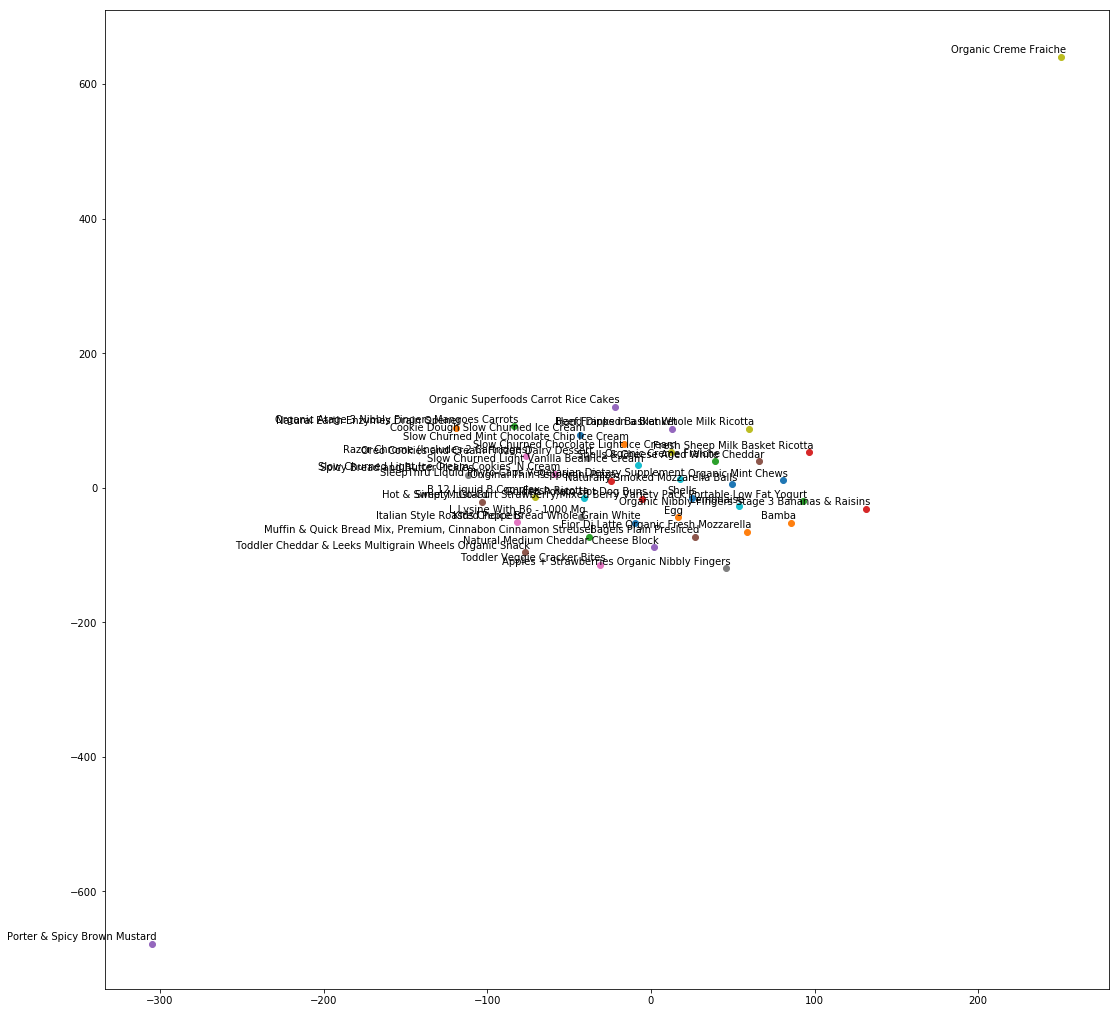

In [29]:
tsne = TSNE()
embeds = []
labels = []
for item in get_batch(vocab, model, n_batches=7):
    embeds.append(model[item])
    labels.append(products.loc[int(item)]['product_name'])
embeds = np.array(embeds)
#tsne 降维处理
embeds = tsne.fit_transform(embeds)
plot_with_labels(embeds, labels)

### Save the model

In [21]:
model.save("product2vec.model")